In [1]:
import qiskit
from qiskit_aer import AerSimulator
# from qiskit.quantum_info import Statevector
from qiskit.circuit.library import QFT
import numpy as np
from numpy import pi
from matplotlib import pyplot as plt

In [2]:
def kinetic_Step(dt,n,trott=1):
    x = qiskit.QuantumRegister(n,'x')
    qc = qiskit.QuantumCircuit(x)
    N = 2**n
    dp = 2*pi/(N)
    b = pi*dp/n
    c = dp**2
    for j in range(n):
        qc.p(1/trott*n*dt*b*2**(n-1-j),j)

    for j in range(n):
        for l in range(0,n):
            if j!=l:
                qc.cp(-1/trott*dt/2*c*2**(2*n-2-j-l),l,j)
            else:
                qc.p(-1/trott*c*dt/2*2**(2*n-2-j-l),j)
    return qc.to_gate()

def harmonic_Pot_Step(dt,n,L,omega=1):
    x = qiskit.QuantumRegister(n,'x')
    qc = qiskit.QuantumCircuit(x)
    dx = L/(2**n)
    b = L/2*dx/n
    c = dx**2
    for j in range(n):
        qc.p(n*omega**2*dt*b*2**(n-1-j),j)

    for j in range(n):
        for l in range(0,n):
            if j!=l:
                qc.cp(-dt/2*omega**2*c*2**(2*n-2-j-l),l,j)
            else:
                qc.p(-c*omega**2*dt/2*2**(2*n-2-j-l),j)
    return qc.to_gate()


In [3]:
def getCircuit(n,initialConditon):
    qc = qiskit.QuantumCircuit(qiskit.QuantumRegister(n,'x'))
    qc.initialize(initialConditon)
    return qc

In [4]:
sim = AerSimulator(method='statevector')

**a)**  For the Free particle the the Hamiltonian $\mathcal{H} = \frac{p^2}{2m}+V(x)$ simplifies to $\mathcal{H}_\textrm{free} = \frac{p^2}{2m}$, thus the  first order Suzuki-Trotter approximation is just $\exp{\left(i\frac{p^2}{2m}\delta t\right)}$. For simplicity $m=1$ is assumed.

In [5]:
n = 8
dt = 1
L=4

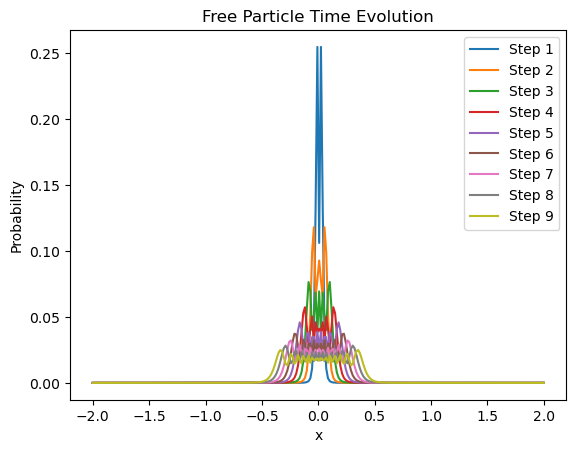

In [6]:
def free_particle_sim(num_steps,dt,n,initialConditon):
    step = kinetic_Step(dt,n)
    for i in range(num_steps):
        qc = getCircuit(n,initialConditon)
        qc.append(QFT(n,do_swaps=False),qc.qubits[:])
        for j in range(i):
            qc.append(step,qc.qubits[:])
        qc.append(QFT(n, inverse=True,do_swaps=False),qc.qubits[:])

        #sim of curcuit
        qc.save_statevector()
        if i!=0:
            statevec =np.abs( sim.run(qiskit.transpile(qc, sim),shots=1000).result().get_statevector(qc))**2
            plt.plot(np.linspace(-L/2, L/2, 2**n),statevec,label = f'Step {i}')

    plt.xlabel("x") # plotting the states in decimal numbered states
    plt.ylabel("Probability")
    plt.title("Free Particle Time Evolution")
    plt.legend()
    plt.show()
free_particle_sim(10,dt,n,2**n//2)

**c)** For the Harmonic Oscillator the Potential reads $V(x) =  \frac{1}{2}m\omega^2x^2$, therefore the  first order Suzuki-Trotter approximation reads $\exp{\left(i\frac{p^2}{2m}\delta t\right)} \exp{\left ( i\delta t V(x) \right)}$. For simplicity $m=1$ is 

In [7]:
n = 10
L=4

In [8]:
def get_Ham_Oszi_Ground_state(L,n):
    x = np.linspace(-L/2, L/2, 2**n)
    psi0 =(1/np.pi)**(1/4)*np.exp(-1/2*x**2)
    return psi0/np.linalg.norm(psi0)
psi_0 = get_Ham_Oszi_Ground_state(L,n)

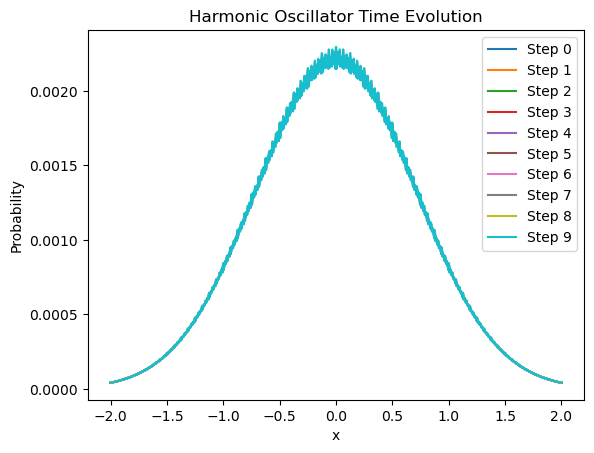

In [9]:
def ham_osci_sim(num_steps,dt,n,L,initialConditon,omega=1):
    step = kinetic_Step(dt,n)
    pot_Step = harmonic_Pot_Step(dt,n,L,omega)
    for i in range(*num_steps):
        qc = getCircuit(n, initialConditon)
        for _ in range(i):
            qc.append(pot_Step,qc.qubits[:])
            qc.append(QFT(n,do_swaps=False),qc.qubits[:])
            qc.append(step,qc.qubits[:])
            qc.append(QFT(n, inverse=True,do_swaps=False),qc.qubits[:])

        #sim of curcuit
        qc.save_statevector()
        # if i!=0:
        statevec =np.abs( sim.run(qiskit.transpile(qc, sim),shots=1000).result().get_statevector(qc))**2
        plt.plot(np.linspace(-L/2, L/2, 2**n),statevec,label = f'Step {i}')

    plt.xlabel("x") 
    plt.ylabel("Probability")
    plt.title("Harmonic Oscillator Time Evolution")
    plt.legend()
    # plt.plot(x, 1/2*x**2)
    plt.show()
ham_osci_sim((0,10),0.01,n,L,psi_0)

Since the intial State is an Eigenstate of the ham. Osci. the phase from the time evolution gets cancelled by taking the absolute square. Therefore no evolution is visible. The fraying of the curve is presumably due to discretization / Trotter approximation errors. It gets larger for grater time steps and lower n.

The latest steps produces the most micro oscillations, and is therefore the only one visible above.